In [4]:
%pylab
%matplotlib inline

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [68]:
import pymc3 as pm
from collections import Counter
import seaborn as sns
import pandas as pd

## 1. Implementación del modelo Beta-Binomial para la moneda

#### Caso uniforme: B(1,1)
Para modelar el _prior_ $\theta$ utilizaremos en este caso, una distribución Beta con sus parámetros $\alpha$ y $\beta$ iguales a 1, lo que es equivalente a una distribución uniforme (Unif(0,1)). Por su parte para modelar $k$ utilizaremos una distribución binomial.
<br>
Se implementarán las distribuciones mencionadas para el experimento de arrojar una moneda al aire 6 veces y en todas ellas se obtuvo "cara".

In [7]:
model_uniform = pm.Model()
with model_uniform:
    theta = pm.Beta('theta_uniform', 1, 1)
    tiradas = pm.Binomial('tiradas', n=6, p=theta, observed=6)
    trace = pm.sample()
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1000/1000 [00:00<00:00, 1343.94it/s]


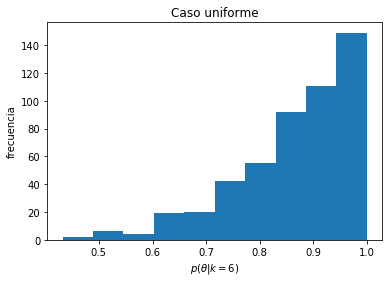

In [9]:
hist(trace.theta_uniform)
title('Caso uniforme')
xlabel(r'$p(\theta | k = 6)$')
ylabel('frecuencia')

A partir de un $\theta$ uniforme se obtuvo que el _posterior_ (p($\theta$|$k$)) indicaría que la moneda está cargada.

#### Caso Honesto: B(100,100)

En este caso el _prior_ se modelará teniendo en cuenta que la probabilidad de sacar "cara" o "ceca" al arrojar la moneda es 0.5 en ambos casos. Es decir, se asume una "moneda honesta".
<br>
Se implementarán las distribuciones mencionadas para el experimento de arrojar una moneda al aire 6 veces y en todas ellas se obtuvo "cara".

In [28]:
model_honest = pm.Model()
with model_honest:
    theta_honest = pm.Beta('theta_honest', 50, 50)  # TODO: cambiar a 100, 100 cuando sepamos como
    tiradas = pm.Binomial('tiradas', n=6, p=theta_honest, observed=6)
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1000/1000 [00:00<00:00, 1606.36it/s]


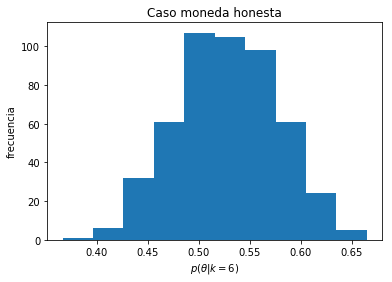

In [29]:
hist(trace.theta_honest)
title('Caso moneda honesta')
xlabel(r'$p(\theta|k = 6)$')
ylabel('frecuencia')

En este caso,a  diferencia del anterior, no se asume desde un primer momento que la moneda está cargada y eso mismo se ve reflejado en la probabilidad p($\theta$|$k$). 

In [30]:
#vemos que la distribucion se centra en 0.5
model_honest = pm.Model()
with model_honest:
    theta_honest_prior = pm.Beta('theta_honest', 50, 50)  # TODO: NUTS no funciona con 100, 100
    trace_prior = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1000/1000 [00:00<00:00, 1308.35it/s]


Si comparamos las distribucion del prior de $\theta$ versus su posterior, vemos que la media se corrió levemente hacia el lado sesgado en _cara_.

In [34]:
print('Media de p(theta): {:.4f}'.format(trace_prior.theta_honest.mean()))
print('Media de p(theta | k = 6): {:.4f}'.format(trace.theta_honest.mean()))

Media de p(theta): 0.4991
Media de p(theta | k = 6): 0.5274


## 2. MAP y medias de las distribuciones

Para lograr una mejor descripción de las probabilidades encontradas en los dos casos de estudio, se calculan el Máximo A Posteriori y las medias.

#### Caso Uniforme

In [141]:
model_uniform = pm.Model()
with model_uniform:
    theta_uniform = pm.Beta('theta_uniform', 1, 1)
    tiradas = pm.Binomial('tiradas', p=theta_uniform, n=6, observed=6)
    trace = pm.sample()
    MAP = pm.find_MAP()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1000/1000 [00:00<00:00, 1341.56it/s]
logp = -0.0023631, ||grad|| = 0.0023627: 100%|██████████| 20/20 [00:00<00:00, 2223.97it/s]  


In [142]:
MAP

{'theta_uniform': array(0.9999984620831801),
 'theta_uniform_logodds__': array(13.385080233683778)}

In [16]:
print('MAP Estimate para beta(1, 1): {}'.format(MAP['theta_uniform']))

MAP Estimate para beta(1, 1): 0.9999984620831801


In [17]:
print('Media para beta(1, 1): {}'.format(mean(trace.theta_uniform)))

Media para beta(1, 1): 0.8773423515808103


#### Caso Honesto

In [18]:
model_honest = pm.Model()
with model_honest:
    theta_honest = pm.Beta('theta_honest', 50, 50)  # TODO
    tiradas = pm.Binomial('tiradas', p=theta_honest, n=6, observed=6)
    trace = pm.sample()
    MAP = pm.find_MAP()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1000/1000 [00:00<00:00, 1176.11it/s]
logp = -2.0846, ||grad|| = 3: 100%|██████████| 6/6 [00:00<00:00, 1293.81it/s]


In [19]:
print('MAP Estimate para beta(50, 50): {}'.format(MAP['theta_honest']))

MAP Estimate para beta(50, 50): 0.5288461537406147


In [20]:
print('Media para beta(50, 50): {}'.format(mean(trace.theta_honest)))

Media para beta(50, 50): 0.5272513239222776


En el caso de prior uniforme, tanto el MAP como la media de la distribución a posteriori de $\theta$ se encuentran cerca del 1, indicando que la moneda está cargada para que salga cara. En cambio, en el caso del prior que asume una moneda honesta, el MAP y la media de la distribución a posteriori siguen cerca de 0.5, aunque con un leve sesgo hacia 1.

## 3. Predicción

Aquí se querrá predecir el resultado de un próximo lanzamiento de moneda teniendo en cuenta la información ya modelada.

#### Caso uniforme

In [37]:
model_uniform = pm.Model()
with model_uniform:
    theta_uniform = pm.Beta('theta_uniform', 1, 1)
    dato = pm.Binomial('dato', p=theta_uniform, n=6, observed=6)
    post_uniform = pm.Binomial('post_uniform', p=theta_uniform, n=6)
    trace = pm.sample()

Assigned NUTS to theta_uniform_logodds__
Assigned Metropolis to post_uniform
 96%|█████████▌| 958/1000 [00:01<00:00, 589.30it/s]/home/march/anaconda2/envs/py3/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:451: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.711744507944, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
100%|██████████| 1000/1000 [00:01<00:00, 591.77it/s]


In [39]:
count = Counter(sort(trace.post_uniform))

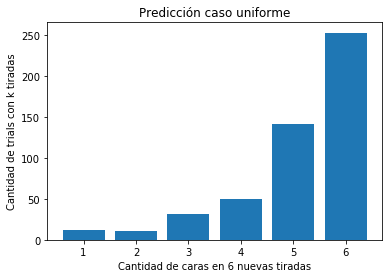

In [47]:
bar(arange(len(count)) + 1, count.values())
title('Predicción caso uniforme')
xlabel('Cantidad de caras en 6 nuevas tiradas')
ylabel('Cantidad de trials con k tiradas')

Teniendo en cuenta el _posterior_ de $\theta$ dado los datos estima que la moneda está cargada, la predicción que se obtiene se ve completamente influenciada resultando mayor la probabilidad que vuelva a salir muchas caras en los próximos lanzamientos.

#### Caso honesto 

In [48]:
model_honest = pm.Model()
with model_honest:
    theta_honest = pm.Beta('theta_honest', 50, 50)
    dato = pm.Binomial('dato', p=theta_honest, n=6, observed=6)
    post_honest = pm.Binomial('post_honest', p=theta_honest, n=6)
    trace = pm.sample()

Assigned NUTS to theta_honest_logodds__
Assigned Metropolis to post_honest
100%|██████████| 1000/1000 [00:01<00:00, 597.35it/s]


In [50]:
count = Counter(sort(trace.post_honest))

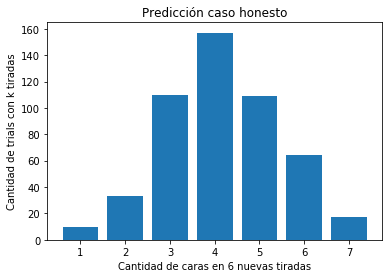

In [52]:
bar(arange(len(count)) + 1, count.values())
title('Predicción caso honesto')
xlabel('Cantidad de caras en 6 nuevas tiradas')
ylabel('Cantidad de trials con k tiradas')

Como era de esperarse, cuando el _prior_ asume una moneda honesta, el _posterior_ mantiene una moneda honesta. De esta forma, la predicción para el resultado de los próximos lanzamientos no indica que es probable tener más caras que cecas.

## 4. Comparaciones entre datos

Con el objetivo de analizar cuánto influyen los datos iniciales y las creencias que son asumidas en el _prior_ se pondrán a prueba dos experimentos que se diferencian en la cantidad de tiradas y resultados obtenidos.

TODO: se podria hacer una funcion que haga lo mismo que en los puntos anteriores y aca solo le cambiamos el n y el k (3, 20). 

In [53]:
def uniforme_vs_honesto(cant_tiradas):
    model_uniform = pm.Model()
    with model_uniform:
        theta_uniform = pm.Beta('theta_uniform', 1, 1)
        tiradas = pm.Binomial('tiradas', p=theta_uniform, n=cant_tiradas, observed=cant_tiradas)
        post_uniform = pm.Binomial('post_uniform', p=theta_uniform, n=cant_tiradas)
        trace_uniforme = pm.sample()
        MAP_uniforme = pm.find_MAP()

    model_honest = pm.Model()
    with model_honest:
        theta_honest = pm.Beta('theta_honest', 50, 50)  # TODO
        tiradas = pm.Binomial('tiradas', p=theta_honest, n=cant_tiradas, observed=cant_tiradas)
        post_honest = pm.Binomial('post_honest', p=theta_honest, n=cant_tiradas)
        trace_honesto = pm.sample()
        MAP_honesto = pm.find_MAP()
        
    return trace_uniforme, MAP_uniforme, trace_honesto, MAP_honesto

### Experimento 1: 20 tiradas, 20 caras

#### Caso uniforme

In [80]:
trace_uniforme_20, MAP_uniforme_20, trace_honesto_20, MAP_honesto_20 = uniforme_vs_honesto(20)
trace_uniforme_3, MAP_uniforme_3, trace_honesto_3, MAP_honesto_3 = uniforme_vs_honesto(3)

Assigned NUTS to theta_uniform_logodds__
Assigned Metropolis to post_uniform
100%|██████████| 1000/1000 [00:01<00:00, 565.94it/s]
logp = -15.599, ||grad|| = 10: 100%|██████████| 7/7 [00:00<00:00, 1492.56it/s]
Assigned NUTS to theta_honest_logodds__
Assigned Metropolis to post_honest
100%|██████████| 1000/1000 [00:01<00:00, 619.35it/s]
logp = -13.525, ||grad|| = 10: 100%|██████████| 6/6 [00:00<00:00, 1389.76it/s]
Assigned NUTS to theta_uniform_logodds__
Assigned Metropolis to post_uniform
100%|██████████| 1000/1000 [00:02<00:00, 459.49it/s]
logp = -3.0603, ||grad|| = 2: 100%|██████████| 8/8 [00:00<00:00, 1580.97it/s]
Assigned NUTS to theta_honest_logodds__
Assigned Metropolis to post_honest
100%|██████████| 1000/1000 [00:01<00:00, 602.29it/s]
logp = -0.98598, ||grad|| = 2: 100%|██████████| 6/6 [00:00<00:00, 1521.42it/s]


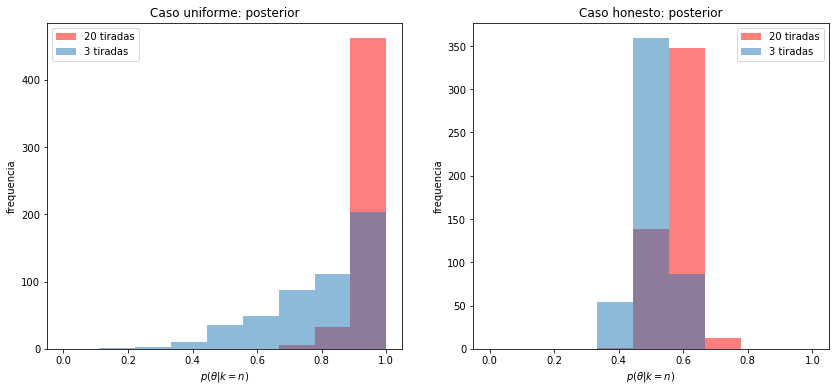

In [74]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

plt.sca(axs[0])
bins = linspace(0, 1, 10)
hist_20 = hist(trace_uniforme_20.theta_uniform, label='20 tiradas', color='red', bins=bins, alpha=0.5)
hist_3 = hist(trace_uniforme_3.theta_uniform, label='3 tiradas', bins=bins, alpha=0.5)
legend()
title('Caso uniforme: posterior')
xlabel(r'$p(\theta | k = n)$')
ylabel('frequencia')

plt.sca(axs[1])
bins = linspace(0, 1, 10)
hist_20 = hist(trace_honesto_20.theta_honest, label='20 tiradas', color='red', bins=bins, alpha=0.5)
hist_3 = hist(trace_honesto_3.theta_honest, label='3 tiradas', bins=bins, alpha=0.5)
legend()
title('Caso honesto: posterior')
xlabel(r'$p(\theta | k = n)$')
ylabel('frequencia')

In [89]:
MAP_uniforme_20

{'post_uniform': array(10),
 'theta_uniform': array(0.7499999999698487),
 'theta_uniform_logodds__': array(1.0986122885073026)}

In [87]:
df_unif = pd.DataFrame({
        'MAP': {'3 tiradas': MAP_uniforme_3['theta_uniform'],
                '20 tiradas': MAP_uniforme_20['theta_uniform']},
        'mean': {'3 tiradas': trace_uniforme_3.theta_uniform.mean(),
                 '20 tiradas': trace_uniforme_20.theta_uniform.mean()}
    })
df_unif.T

,20 tiradas,3 tiradas
MAP,0.7499999999698487,0.8333333324331214
mean,0.964942,0.805534


In [101]:
from sklearn.neighbors import KernelDensity

In [137]:
def dens(n_mas):
    data = random.beta(1 + n_mas, 1, 1000)

    kd = KernelDensity()
    kd.fit(data.reshape((-1, 1)))

    xs = linspace(0, 1, 1000)
    ys = kd.score_samples(xs.reshape((-1, 1)))
    plot(xs, pow(np.e, ys), label=str(n_mas))
    vlines(data.mean(), ymin=0, ymax=0.4)

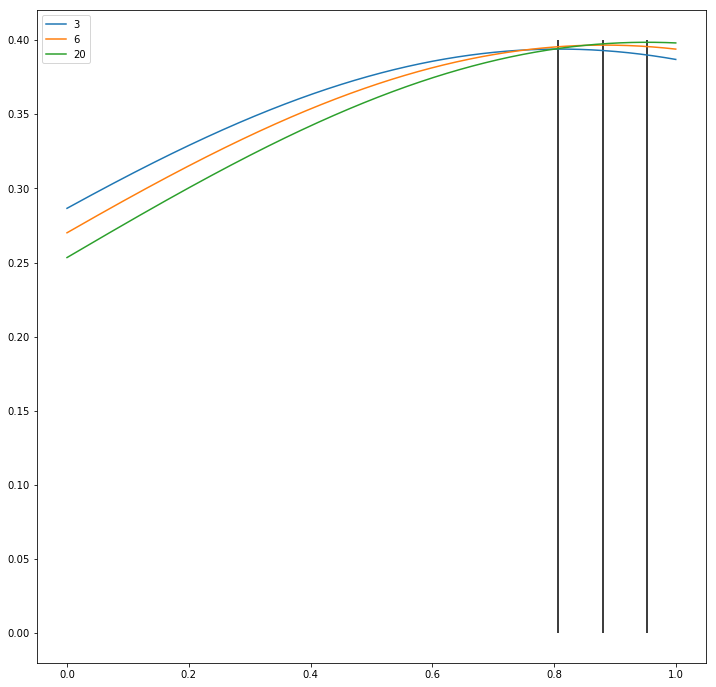

In [140]:
fig = plt.figure(figsize=(12, 12))
dens(3)
dens(6)
dens(20)
legend()